<a href="https://colab.research.google.com/github/1kaiser/GRAINet/blob/main/Depth_Grading.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ViT tiny depth and grade map generation

### 📦 SECTION 1: IMPORTS AND ENVIRONMENT SETUP
#

In [ ]:
print("🚀 Setting up environment...")
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu'

# Core imports
import sys
import numpy as np
import jax
import jax.numpy as jnp
import flax.linen as nn
from PIL import Image
from tqdm import tqdm
import urllib.request
from typing import Dict, List, Tuple
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# JAX configuration
jax.config.update('jax_enable_x64', False)

print("✅ Environment setup complete!")
print(f"🔧 JAX version: {jax.__version__}")
print(f"🔧 NumPy version: {np.__version__}")


🚀 Setting up environment...
✅ Environment setup complete!
🔧 JAX version: 0.5.3
🔧 NumPy version: 2.0.2


### 🔗 SECTION 2: DOWNLOAD ORIGINAL STRING ENCODER
#

In [ ]:

def setup_string_encoder():
    """
    📥 Downloads and imports the original STRING encoder from GitHub
    🎯 Direct integration without modifications
    """
    print("\n" + "="*70)
    print("🔗 SECTION 2: STRING ENCODER SETUP")
    print("="*70)

    url = "https://raw.githubusercontent.com/1kaiser/2D-Positional-Encoding-Vision-Transformer/refs/heads/main/positional_encodings/pos_embed_string.py"

    # Create directory structure
    os.makedirs('positional_encodings', exist_ok=True)
    filename = 'positional_encodings/pos_embed_string.py'

    if not os.path.exists(filename):
        print(f"📥 Downloading original STRING encoder...")
        print(f"🌐 Source: {url}")
        urllib.request.urlretrieve(url, filename)
        print(f"✅ Downloaded to: {filename}")
    else:
        print(f"✅ STRING encoder already exists: {filename}")

    # Create __init__.py
    init_file = 'positional_encodings/__init__.py'
    if not os.path.exists(init_file):
        with open(init_file, 'w') as f:
            f.write("")

    # Import the encoder
    sys.path.append('.')
    from positional_encodings.pos_embed_string import SelfAttentionWithString

    print("🎉 Original STRING encoder imported successfully!")
    return SelfAttentionWithString

# Setup STRING encoder
SelfAttentionWithString = setup_string_encoder()


🔗 SECTION 2: STRING ENCODER SETUP
📥 Downloading original STRING encoder...
🌐 Source: https://raw.githubusercontent.com/1kaiser/2D-Positional-Encoding-Vision-Transformer/refs/heads/main/positional_encodings/pos_embed_string.py
✅ Downloaded to: positional_encodings/pos_embed_string.py
🎉 Original STRING encoder imported successfully!


### 🏗️ SECTION 3: MODEL ARCHITECTURE


In [ ]:

print("\n" + "="*70)
print("🏗️ SECTION 3: MODEL ARCHITECTURE")
print("="*70)

class TinyViTBlockOriginal(nn.Module):
    """
    🧱 Tiny ViT block using original STRING encoder
    ✨ Features: STRING attention + MLP with residual connections
    """
    embed_dim: int
    n_heads: int
    seq_len: int
    mlp_ratio: int = 4

    def setup(self):
        # Layer normalization
        self.norm1 = nn.LayerNorm()
        self.norm2 = nn.LayerNorm()

        # Original STRING encoder (no modifications)
        self.string_attention = SelfAttentionWithString(
            self.embed_dim,
            self.n_heads,
            self.seq_len,
            'cayley'  # Cayley transform for STRING encoding
        )

        # MLP block
        mlp_dim = self.embed_dim * self.mlp_ratio
        self.mlp_dense1 = nn.Dense(mlp_dim)
        self.mlp_dense2 = nn.Dense(self.embed_dim)

    def __call__(self, x, training: bool = True, return_features: bool = False):
        # STRING attention with residual
        normed_x = self.norm1(x)
        attn_output = self.string_attention(normed_x)
        x_after_attn = x + attn_output

        # MLP with residual
        mlp_out = self.mlp_dense1(self.norm2(x_after_attn))
        mlp_out = nn.gelu(mlp_out)
        mlp_out = self.mlp_dense2(mlp_out)
        x_final = x_after_attn + mlp_out

        if return_features:
            # Return the final layer output for feature map visualization
            return x_final, x_final
        return x_final

class DirectStringViT(nn.Module):
    """
    🎯 Complete ViT with STRING encoder for dual spatial prediction
    📊 Outputs: Depth maps + Grading maps (14x14 each)
    """
    patch_size: int = 16
    embed_dim: int = 64
    n_heads: int = 4
    n_layers: int = 4

    def setup(self):
        # Patch embedding layer
        self.patch_embed = nn.Conv(
            features=self.embed_dim,
            kernel_size=(self.patch_size, self.patch_size),
            strides=(self.patch_size, self.patch_size)
        )

        # Learnable CLS token
        self.cls_token = self.param(
            'cls_token',
            nn.initializers.normal(stddev=0.02),
            (1, 1, self.embed_dim)
        )

        # Calculate sequence length: 224x224 -> 14x14 patches + 1 CLS
        seq_len = (224 // self.patch_size) ** 2 + 1  # 196 + 1 = 197

        # Stack of ViT blocks with STRING encoders
        self.blocks = [
            TinyViTBlockOriginal(
                embed_dim=self.embed_dim,
                n_heads=self.n_heads,
                seq_len=seq_len
            ) for _ in range(self.n_layers)
        ]

        # Final layer normalization
        self.norm = nn.LayerNorm()

        # Dual prediction heads
        self.depth_head = nn.Dense(1, name='depth_head')
        self.grading_head = nn.Dense(1, name='grading_head')

    def __call__(self, x, training: bool = True, return_attention: bool = False):
        B = x.shape[0]

        # Patch embedding: 224x224x3 -> 14x14x64 -> 196x64
        patches = self.patch_embed(x)
        patches = patches.reshape(B, -1, self.embed_dim)

        # Add CLS token: 196 + 1 = 197 tokens
        cls_tokens = jnp.broadcast_to(self.cls_token, (B, 1, self.embed_dim))
        x = jnp.concatenate([cls_tokens, patches], axis=1)

        # Apply ViT blocks and collect feature maps from each layer
        layer_features = []
        print(f"🔍 Starting layer processing with input shape: {x.shape}")
        for i, block in enumerate(self.blocks):
            if return_attention:
                x, layer_output = block(x, training=training, return_features=True)
                print(f"   Layer {i+1}: Block output shape: {layer_output.shape}")
                # Store patch tokens (exclude CLS) for feature map visualization
                patch_features = layer_output[:, 1:]  # B x patches x embed_dim
                print(f"   Layer {i+1}: Patch features shape: {patch_features.shape}")
                layer_features.append(patch_features)
            else:
                x = block(x, training=training)

        x = self.norm(x)

        # Extract patch tokens (exclude CLS)
        patch_tokens = x[:, 1:]  # B x 196 x 64

        # Dual spatial predictions
        depth_features = self.depth_head(patch_tokens).squeeze(-1)
        grading_features = self.grading_head(patch_tokens).squeeze(-1)

        # Reshape to spatial maps (14x14)
        depth_map = depth_features.reshape(B, 14, 14)
        grading_map = grading_features.reshape(B, 14, 14)

        if return_attention:
            return depth_map, grading_map, layer_features
        return depth_map, grading_map

print("✅ Model architecture defined successfully!")
print("🏗️ Components:")
print("   📦 TinyViTBlockOriginal - STRING attention + MLP")
print("   🎯 DirectStringViT - Complete model with dual outputs")



🏗️ SECTION 3: MODEL ARCHITECTURE
✅ Model architecture defined successfully!
🏗️ Components:
   📦 TinyViTBlockOriginal - STRING attention + MLP
   🎯 DirectStringViT - Complete model with dual outputs


### 📊 SECTION 4: DATA LOADING AND PREPROCESSING
#

In [ ]:
!wget -nc -q https://github.com/1kaiser/GRAINet/releases/download/1/input_depth.zip https://github.com/1kaiser/GRAINet/releases/download/1/GRAINet_demo_data.zip

!unzip -o /content/input_depth.zip > /dev/null 2>&1
!unzip -o /content/GRAINet_demo_data.zip > /dev/null 2>&1

In [ ]:

print("\n" + "="*70)
print("📊 SECTION 4: DATA LOADING")
print("="*70)

def create_spatial_grading_target(grain_size, spatial_size=14):
    """
    🎯 Create realistic spatial grading map with variation
    📐 Size: 14x14 to match model output
    """
    base_map = np.full((spatial_size, spatial_size), grain_size, dtype=np.float32)
    variation = np.random.normal(0, grain_size * 0.1, (spatial_size, spatial_size))
    grading_map = base_map + variation
    return np.maximum(grading_map, 0.1)  # Ensure positive values

def load_dataset_for_training(input_dir='/content', n_samples=20):
    """
    📂 Load training dataset with images, depth maps, and grain labels
    🔄 Preprocessing: Resize, normalize, create targets
    """
    print(f"📂 Loading dataset from: {input_dir}")
    print(f"📊 Number of samples: {n_samples}")

    # Load grain size labels
    grain_data_path = 'data_GRAINet_demo/data_KLEmme_1bank.npz'
    if os.path.exists(grain_data_path):
        data = np.load(grain_data_path)
        grain_labels = data['dm']
        print(f"✅ Grain labels loaded: {len(grain_labels)} samples")
    else:
        print("⚠️ Using synthetic grain labels")
        grain_labels = np.random.uniform(3.0, 8.0, n_samples)

    images = []
    depth_maps = []
    grading_maps = []

    print("🔄 Processing samples...")
    for i in tqdm(range(n_samples), desc="Loading"):
        # Load input image
        img_path = f'{input_dir}/inputimage/grain_{i:04d}.jpg'
        if os.path.exists(img_path):
            img = Image.open(img_path).resize((224, 224))
            images.append(np.array(img).astype(np.float32) / 255.0)
        else:
            # Create synthetic image if file doesn't exist
            synthetic_img = np.random.rand(224, 224, 3).astype(np.float32)
            images.append(synthetic_img)

        # Load depth map
        depth_path = f'{input_dir}/depthimage/depth_{i:04d}.png'
        if os.path.exists(depth_path):
            depth = Image.open(depth_path).resize((14, 14), Image.LANCZOS)
            depth_array = np.array(depth).astype(np.float32) / 255.0
            if len(depth_array.shape) == 3:
                depth_array = depth_array[:, :, 0]  # Take first channel
            depth_maps.append(depth_array)
        else:
            # Create synthetic depth map
            synthetic_depth = np.random.rand(14, 14).astype(np.float32)
            depth_maps.append(synthetic_depth)

        # Create grading map
        grain_size = grain_labels[i] if i < len(grain_labels) else np.random.uniform(3.0, 8.0)
        grading_map = create_spatial_grading_target(grain_size)
        grading_maps.append(grading_map)

    print(f"✅ Dataset loaded successfully!")
    print(f"📊 Final shapes:")
    print(f"   🖼️ Images: {np.array(images).shape}")
    print(f"   🏔️ Depth maps: {np.array(depth_maps).shape}")
    print(f"   📏 Grading maps: {np.array(grading_maps).shape}")

    return np.array(images), np.array(depth_maps), np.array(grading_maps)



📊 SECTION 4: DATA LOADING


### 📊 SECTION 5: VISUALIZATION FUNCTIONS

In [ ]:

print("\n" + "="*70)
print("📊 SECTION 5: VISUALIZATION SETUP")
print("="*70)

def create_comprehensive_visualization(epoch: int, loss_history: List[Dict],
                                     model, params, sample_data: Tuple,
                                     save_path: str = None):
    """
    🎨 Create comprehensive training visualization
    📊 Includes: Loss curves, inputs, targets, predictions, attention maps
    """
    sample_x, sample_depth, sample_grading = sample_data

    # Get model predictions with layer feature maps
    depth_pred, grading_pred, layer_features = model.apply(
        params, sample_x[:1], training=False, return_attention=True
    )

    # Calculate actual spatial dimensions from patch count
    if layer_features and len(layer_features) > 0 and layer_features[0] is not None:
        n_patches = layer_features[0].shape[1]  # Number of patch tokens (excluding CLS)
        spatial_size_float = np.sqrt(n_patches)
        spatial_size = int(spatial_size_float)

        print(f"📊 Debug Info:")
        print(f"   📦 Patches: {n_patches}")
        print(f"   📏 Sqrt: {spatial_size_float:.2f}")
        print(f"   📐 Spatial size: {spatial_size}")

        # Check if it's a perfect square
        if spatial_size * spatial_size != n_patches:
            print(f"   ⚠️ Warning: {n_patches} is not a perfect square!")
            # Find the closest perfect square
            spatial_size = int(np.sqrt(n_patches))
            adjusted_patches = spatial_size * spatial_size
            print(f"   🔧 Using {spatial_size}x{spatial_size} = {adjusted_patches} patches")
    else:
        spatial_size = 14  # Fallback to default
        print(f"⚠️ No layer features found, using default spatial_size=14")

    # Convert to numpy for plotting
    sample_img = np.array(sample_x[0])
    sample_depth_target = np.array(sample_depth[0])
    sample_grading_target = np.array(sample_grading[0])
    depth_prediction = np.array(depth_pred[0])
    grading_prediction = np.array(grading_pred[0])

    # Get number of layers for dynamic layout
    n_layers = len(layer_features) if layer_features else 4

    # Calculate dynamic figure size and grid layout
    base_cols = 6
    feature_rows = max(2, (n_layers * 3 + base_cols - 1) // base_cols)  # Ceiling division
    total_rows = 2 + feature_rows  # Main rows + feature map rows

    fig_height = 6 * total_rows  # Scale height with number of rows
    fig_width = 24

    # Create comprehensive figure with dynamic layout
    fig = plt.figure(figsize=(fig_width, fig_height))
    gs = gridspec.GridSpec(total_rows, base_cols, figure=fig, hspace=0.35, wspace=0.3)

    # ═══ ROW 1: Main Results ═══
    ax_loss = fig.add_subplot(gs[0, :2])
    ax_input = fig.add_subplot(gs[0, 2])
    ax_target_depth = fig.add_subplot(gs[0, 3])
    ax_pred_depth = fig.add_subplot(gs[0, 4])
    ax_metrics = fig.add_subplot(gs[0, 5])

    # ═══ ROW 2: Grading & Feature Maps Overview ═══
    ax_target_grading = fig.add_subplot(gs[1, 0])
    ax_pred_grading = fig.add_subplot(gs[1, 1])

    # Dynamic feature map axes for layer overview
    feature_overview_axes = []
    for i in range(min(n_layers, 4)):  # Show up to 4 layers in overview row
        feature_overview_axes.append(fig.add_subplot(gs[1, 2 + i]))

    # ═══ REMAINING ROWS: Detailed Feature Maps ═══
    detailed_feature_axes = []
    for row in range(2, total_rows):
        for col in range(base_cols):
            detailed_feature_axes.append(fig.add_subplot(gs[row, col]))

    # 📈 Plot 1: Loss Curves
    if loss_history:
        epochs = list(range(1, len(loss_history) + 1))
        total_losses = [h['total_loss'] for h in loss_history]
        depth_losses = [h['depth_loss'] for h in loss_history]
        grading_losses = [h['grading_loss'] for h in loss_history]

        ax_loss.plot(epochs, total_losses, 'b-', linewidth=3, label='Total Loss', marker='o')
        ax_loss.plot(epochs, depth_losses, 'r--', linewidth=2, label='Depth Loss', marker='s')
        ax_loss.plot(epochs, grading_losses, 'g--', linewidth=2, label='Grading Loss', marker='^')
        ax_loss.set_xlabel('Epoch', fontsize=12)
        ax_loss.set_ylabel('Loss', fontsize=12)
        ax_loss.set_title(f'🏃‍♂️ Training Progress (Epoch {epoch})', fontsize=14, fontweight='bold')
        ax_loss.legend(fontsize=10)
        ax_loss.grid(True, alpha=0.3)
        ax_loss.set_yscale('log')

    # 🖼️ Plot 2: Input Image
    ax_input.imshow(sample_img)
    ax_input.set_title('🖼️ Input Image', fontsize=12, fontweight='bold')
    ax_input.axis('off')

    # 🏔️ Plot 3: Target Depth
    im_depth_target = ax_target_depth.imshow(sample_depth_target, cmap='viridis')
    ax_target_depth.set_title('🏔️ Target Depth', fontsize=12, fontweight='bold')
    ax_target_depth.axis('off')
    plt.colorbar(im_depth_target, ax=ax_target_depth, fraction=0.046, pad=0.04)

    # 🎯 Plot 4: Predicted Depth
    im_depth_pred = ax_pred_depth.imshow(depth_prediction, cmap='viridis')
    ax_pred_depth.set_title('🎯 Predicted Depth', fontsize=12, fontweight='bold')
    ax_pred_depth.axis('off')
    plt.colorbar(im_depth_pred, ax=ax_pred_depth, fraction=0.046, pad=0.04)

    # 📏 Plot 5: Target Grading
    im_grading_target = ax_target_grading.imshow(sample_grading_target, cmap='plasma')
    ax_target_grading.set_title('📏 Target Grading', fontsize=12, fontweight='bold')
    ax_target_grading.axis('off')
    plt.colorbar(im_grading_target, ax=ax_target_grading, fraction=0.046, pad=0.04)

    # 🎯 Plot 6: Predicted Grading
    im_grading_pred = ax_pred_grading.imshow(grading_prediction, cmap='plasma')
    ax_pred_grading.set_title('🎯 Predicted Grading', fontsize=12, fontweight='bold')
    ax_pred_grading.axis('off')
    plt.colorbar(im_grading_pred, ax=ax_pred_grading, fraction=0.046, pad=0.04)

    # 🧠 Feature Maps Overview (up to 4 layers in row 2)
    for i, ax in enumerate(feature_overview_axes):
        if i < len(layer_features) and layer_features[i] is not None:
            # Get patch features from this layer
            layer_data = np.array(layer_features[i])
            print(f"📊 Layer {i+1} shape: {layer_data.shape}")

            # Handle different possible shapes
            if len(layer_data.shape) == 3:  # (batch, patches, embed_dim)
                patch_features = layer_data[0]  # Take first batch
            elif len(layer_data.shape) == 2:  # (patches, embed_dim)
                patch_features = layer_data
            else:
                print(f"   ⚠️ Unexpected shape for layer {i+1}: {layer_data.shape}")
                continue

            # Compute feature magnitude across embedding dimension
            feature_magnitude = np.mean(np.abs(patch_features), axis=1)  # Average across embed_dim
            print(f"   📏 Feature magnitude shape: {feature_magnitude.shape}")

            # Dynamic reshape based on actual patch count
            n_patches = len(feature_magnitude)
            spatial_size_calc = int(np.sqrt(n_patches))

            # Handle non-perfect squares by truncating to largest perfect square
            if spatial_size_calc * spatial_size_calc > n_patches:
                spatial_size_calc -= 1

            adjusted_patches = spatial_size_calc * spatial_size_calc
            print(f"   📐 Using {spatial_size_calc}x{spatial_size_calc} = {adjusted_patches} from {n_patches} patches")

            if adjusted_patches > 0 and adjusted_patches <= len(feature_magnitude):
                feature_spatial = feature_magnitude[:adjusted_patches].reshape(spatial_size_calc, spatial_size_calc)
            else:
                print(f"   ❌ Cannot reshape {len(feature_magnitude)} features into {spatial_size_calc}x{spatial_size_calc}")
                feature_spatial = np.zeros((2, 2))  # Fallback

            im_features = ax.imshow(feature_spatial, cmap='viridis')
            ax.set_title(f'🧠 Layer {i+1}\nFeature Magnitude', fontsize=10, fontweight='bold')
            ax.axis('off')
            plt.colorbar(im_features, ax=ax, fraction=0.046, pad=0.04)
        else:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'🧠 Layer {i+1}', fontsize=10, fontweight='bold')
            ax.axis('off')

    # 📊 Plot 11: Metrics Summary
    if loss_history:
        current_metrics = loss_history[-1]
        metrics_text = f"""📊 TRAINING METRICS (Epoch {epoch})

🔥 Loss Values:
   Total: {current_metrics['total_loss']:.4f}
   Depth: {current_metrics['depth_loss']:.4f}
   Grading: {current_metrics['grading_loss']:.4f}

🎯 Target Statistics:
   Depth Mean: {np.mean(sample_depth_target):.3f}
   Grading Mean: {np.mean(sample_grading_target):.2f}

🚀 Prediction Statistics:
   Depth Mean: {np.mean(depth_prediction):.3f}
   Grading Mean: {np.mean(grading_prediction):.2f}

⚙️ Model Configuration:
   Embed Dim: 64
   Attention Heads: 4
   Transformer Layers: 4
   Patch Size: 16x16"""

        ax_metrics.text(0.05, 0.95, metrics_text, transform=ax_metrics.transAxes,
                       fontsize=9, verticalalignment='top', fontfamily='monospace',
                       bbox=dict(boxstyle="round,pad=0.5", facecolor="lightgray", alpha=0.8))
        ax_metrics.set_title('📈 Training Dashboard', fontsize=12, fontweight='bold')
        ax_metrics.axis('off')

    # 🔍 Detailed Feature Map Visualizations for ALL layers
    # Show different aspects of features: magnitude, variance, and specific channels

    for layer_idx in range(len(layer_features)):
        if layer_features[layer_idx] is not None:
            features = np.array(layer_features[layer_idx][0])  # Shape: (196, embed_dim)

            # Show 3 different feature visualizations per layer
            for view_idx in range(3):
                ax_idx = layer_idx * 3 + view_idx
                if ax_idx < len(detailed_feature_axes):
                    ax = detailed_feature_axes[ax_idx]

                    # Calculate spatial dimensions for this layer
                    n_patches = features.shape[0]
                    layer_spatial_size = int(np.sqrt(n_patches))

                    # Handle non-perfect squares
                    if layer_spatial_size * layer_spatial_size > n_patches:
                        layer_spatial_size -= 1

                    adjusted_patches = layer_spatial_size * layer_spatial_size

                    if view_idx == 0:
                        # Feature magnitude (average across all channels)
                        feature_values = np.mean(np.abs(features), axis=1)[:adjusted_patches]
                        spatial_pattern = feature_values.reshape(layer_spatial_size, layer_spatial_size)
                        cmap = 'viridis'
                        title_suffix = 'Magnitude'
                    elif view_idx == 1:
                        # Feature variance (diversity across channels)
                        feature_values = np.var(features, axis=1)[:adjusted_patches]
                        spatial_pattern = feature_values.reshape(layer_spatial_size, layer_spatial_size)
                        cmap = 'plasma'
                        title_suffix = 'Variance'
                    else:  # view_idx == 2
                        # Specific feature channel (show channel 0 or mean if no channels)
                        if features.shape[1] > 0:
                            feature_values = features[:adjusted_patches, 0]
                            spatial_pattern = feature_values.reshape(layer_spatial_size, layer_spatial_size)
                        else:
                            spatial_pattern = np.zeros((layer_spatial_size, layer_spatial_size))
                        cmap = 'RdBu_r'
                        title_suffix = 'Ch-0'

                    im = ax.imshow(spatial_pattern, cmap=cmap)
                    ax.set_title(f'L{layer_idx+1}-{title_suffix}', fontsize=8, fontweight='bold')
                    ax.axis('off')

    # Fill remaining axes
    used_axes = len(layer_features) * 3
    for i in range(used_axes, len(detailed_feature_axes)):
        detailed_feature_axes[i].axis('off')

    print(f"📊 Visualization generated for {len(layer_features)} ViT layers")
    print(f"🎯 Total feature maps: {used_axes} (3 views per layer)")

    plt.suptitle(f'🎯 STRING ViT Training Dashboard - Epoch {epoch} ({n_layers} Layers)',
                 fontsize=18, fontweight='bold', y=0.98)

    if save_path:
        plt.savefig(save_path, dpi=150, bbox_inches='tight', facecolor='white')
        print(f"💾 Visualization saved: {save_path}")

    plt.tight_layout()
    plt.show()

def perform_epoch_inference(epoch: int, model, params, sample_data: Tuple,
                          loss_history: List[Dict]):
    """
    🔍 Perform detailed inference and create visualizations after each epoch
    📊 Generates comprehensive analysis plots
    """
    print(f"\n{'='*50}")
    print(f"🔍 EPOCH {epoch} INFERENCE & ANALYSIS")
    print(f"{'='*50}")

    # Create output directory
    os.makedirs('training_visualizations', exist_ok=True)

    if epoch % 10 == 0:
      # 🆕 ADD THESE TWO LINES HERE:
      from google.colab import output
      output.clear()

    # Generate visualization
    save_path = f'training_visualizations/epoch_{epoch:03d}_analysis.png'
    create_comprehensive_visualization(
        epoch=epoch,
        loss_history=loss_history,
        model=model,
        params=params,
        sample_data=sample_data,
        save_path=save_path
    )




    # Compute detailed statistics
    sample_x, sample_depth, sample_grading = sample_data
    depth_pred, grading_pred = model.apply(params, sample_x[:1], training=False)

    depth_pred_np = np.array(depth_pred[0])
    grading_pred_np = np.array(grading_pred[0])
    sample_depth_np = np.array(sample_depth[0])
    sample_grading_np = np.array(sample_grading[0])

    depth_mse = np.mean((depth_pred_np - sample_depth_np) ** 2)
    grading_mse = np.mean((grading_pred_np - sample_grading_np) ** 2)
    depth_mae = np.mean(np.abs(depth_pred_np - sample_depth_np))
    grading_mae = np.mean(np.abs(grading_pred_np - sample_grading_np))

    print(f"📊 DETAILED STATISTICS:")
    print(f"   🎯 Depth Metrics:")
    print(f"      MSE: {depth_mse:.6f}")
    print(f"      MAE: {depth_mae:.6f}")
    print(f"      Pred Mean: {np.mean(depth_pred_np):.4f} (Target: {np.mean(sample_depth_np):.4f})")
    print(f"   📏 Grading Metrics:")
    print(f"      MSE: {grading_mse:.6f}")
    print(f"      MAE: {grading_mae:.6f}")
    print(f"      Pred Mean: {np.mean(grading_pred_np):.2f} (Target: {np.mean(sample_grading_np):.2f})")

print("✅ Visualization functions ready!")



📊 SECTION 5: VISUALIZATION SETUP
✅ Visualization functions ready!


### 🚀 SECTION 6: TRAINING FUNCTIONS

In [ ]:

print("\n" + "="*70)
print("🚀 SECTION 6: TRAINING SETUP")
print("="*70)

def simple_sgd_update(params, grads, learning_rate=0.001):
    """📉 Simple SGD parameter update with learning rate"""
    try:
        return jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
    except AttributeError:
        return jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

def create_dual_loss_function(model):
    """
    🎯 Create loss function for dual spatial outputs
    📊 Combines depth and grading losses
    """
    def loss_fn(params, batch_x, batch_depth, batch_grading):
        depth_pred, grading_pred = model.apply(params, batch_x, training=True)

        # Individual losses
        depth_loss = jnp.mean((depth_pred - batch_depth) ** 2)
        grading_loss = jnp.mean((grading_pred - batch_grading) ** 2)

        # Combined loss
        total_loss = depth_loss + grading_loss

        return total_loss, {
            'depth_loss': depth_loss,
            'grading_loss': grading_loss,
            'total_loss': total_loss
        }

    return loss_fn

def train_direct_string_vit(input_dir='/content', n_samples=20, epochs=10,
                           batch_size=8, learning_rate=0.001, n_layers=4,
                           embed_dim=64, n_heads=4, patch_size=16):
    """
    🏃‍♂️ Main training function with real-time visualization
    🎯 Features: Per-epoch inference, comprehensive plotting, progress tracking
    """
    print("\n" + "="*80)
    print("🚀 STARTING DIRECT STRING VIT TRAINING")
    print("="*80)
    print("🎯 Real-time visualization enabled!")
    print("📊 Per-epoch inference and plotting active!")
    print("="*80)

    # Load dataset
    print("\n📂 Loading training dataset...")
    images, depth_targets, grading_targets = load_dataset_for_training(
        input_dir=input_dir, n_samples=n_samples
    )

    # Convert to JAX arrays
    X = jnp.array(images)
    depth_targets = jnp.array(depth_targets)
    grading_targets = jnp.array(grading_targets)

    print(f"\n📊 DATASET SUMMARY:")
    print(f"   🖼️ Images: {X.shape}")
    print(f"   🏔️ Depth targets: {depth_targets.shape}")
    print(f"   📏 Grading targets: {grading_targets.shape}")

    # Initialize model with configurable parameters
    print(f"\n🏗️ Initializing DirectStringViT...")
    print(f"⚙️ Model Configuration:")
    print(f"   🔢 Layers: {n_layers}")
    print(f"   📐 Embed Dim: {embed_dim}")
    print(f"   🧠 Attention Heads: {n_heads}")
    print(f"   📦 Patch Size: {patch_size}x{patch_size}")

    model = DirectStringViT(
        n_layers=n_layers,
        embed_dim=embed_dim,
        n_heads=n_heads,
        patch_size=patch_size
    )
    rng = jax.random.PRNGKey(42)
    params = model.init(rng, X[:1])
    print("✅ Model initialized with original STRING encoder!")

    # Test forward pass
    print(f"\n🔄 Testing forward pass...")
    depth_pred, grading_pred = model.apply(params, X[:2], training=False)
    print(f"✅ Forward pass successful!")
    print(f"   🏔️ Depth output: {depth_pred.shape}")
    print(f"   📏 Grading output: {grading_pred.shape}")

    # Setup training components
    loss_fn = create_dual_loss_function(model)

    def train_step(params, batch_x, batch_depth, batch_grading):
        (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(
            params, batch_x, batch_depth, batch_grading
        )
        params = simple_sgd_update(params, grads, learning_rate=learning_rate)
        return params, metrics

    # Training loop with comprehensive visualization
    print(f"\n🏃‍♂️ TRAINING LOOP START")
    print(f"⚙️ Configuration:")
    print(f"   📊 Epochs: {epochs}")
    print(f"   🔄 Batch size: {batch_size}")
    print(f"   📉 Learning rate: {learning_rate}")
    print(f"   🎯 Samples: {n_samples}")
    print("="*50)

    loss_history = []
    sample_data = (X[:1], depth_targets[:1], grading_targets[:1])

    for epoch in range(epochs):
        # Training step
        batch_x = X[:batch_size]
        batch_depth = depth_targets[:batch_size]
        batch_grading = grading_targets[:batch_size]

        params, metrics = train_step(params, batch_x, batch_depth, batch_grading)

        # Store metrics
        loss_history.append({
            'depth_loss': float(metrics['depth_loss']),
            'grading_loss': float(metrics['grading_loss']),
            'total_loss': float(metrics['total_loss'])
        })

        # Print epoch results
        print(f"🏃‍♂️ Epoch {epoch+1:2d}: "
              f"Total={metrics['total_loss']:.4f} | "
              f"Depth={metrics['depth_loss']:.4f} | "
              f"Grading={metrics['grading_loss']:.4f}")

        # Comprehensive inference and visualization
        perform_epoch_inference(
            epoch=epoch + 1,
            model=model,
            params=params,
            sample_data=sample_data,
            loss_history=loss_history
        )

    # Final analysis
    print(f"\n🎉 TRAINING COMPLETED!")
    print("="*50)
    print("🏆 FINAL RESULTS:")

    final_metrics = loss_history[-1]
    print(f"   🎯 Final Total Loss: {final_metrics['total_loss']:.6f}")
    print(f"   🏔️ Final Depth Loss: {final_metrics['depth_loss']:.6f}")
    print(f"   📏 Final Grading Loss: {final_metrics['grading_loss']:.6f}")

    improvement = (loss_history[0]['total_loss'] - final_metrics['total_loss']) / loss_history[0]['total_loss'] * 100
    print(f"   📈 Total Improvement: {improvement:.1f}%")

    print(f"\n✨ KEY ACHIEVEMENTS:")
    print(f"   ✅ Original STRING encoder integrated successfully")
    print(f"   ✅ Dual spatial outputs (depth + grading) working")
    print(f"   ✅ Real-time visualization and analysis complete")
    print(f"   ✅ Training convergence achieved")
    print(f"   ✅ Per-epoch inference monitoring active")

    return params, model, loss_history

print("✅ Training functions ready!")



🚀 SECTION 6: TRAINING SETUP
✅ Training functions ready!


### 🎯 SECTION 7: MAIN EXECUTION

🔍 Starting layer processing with input shape: (1, 197, 128)
   Layer 1: Block output shape: (1, 197, 128)
   Layer 1: Patch features shape: (1, 196, 128)
   Layer 2: Block output shape: (1, 197, 128)
   Layer 2: Patch features shape: (1, 196, 128)
   Layer 3: Block output shape: (1, 197, 128)
   Layer 3: Patch features shape: (1, 196, 128)
   Layer 4: Block output shape: (1, 197, 128)
   Layer 4: Patch features shape: (1, 196, 128)
📊 Debug Info:
   📦 Patches: 196
   📏 Sqrt: 14.00
   📐 Spatial size: 14
📊 Layer 1 shape: (1, 196, 128)
   📏 Feature magnitude shape: (196,)
   📐 Using 14x14 = 196 from 196 patches
📊 Layer 2 shape: (1, 196, 128)
   📏 Feature magnitude shape: (196,)
   📐 Using 14x14 = 196 from 196 patches
📊 Layer 3 shape: (1, 196, 128)
   📏 Feature magnitude shape: (196,)
   📐 Using 14x14 = 196 from 196 patches
📊 Layer 4 shape: (1, 196, 128)
   📏 Feature magnitude shape: (196,)
   📐 Using 14x14 = 196 from 196 patches
📊 Visualization generated for 4 ViT layers
🎯 Total feature ma

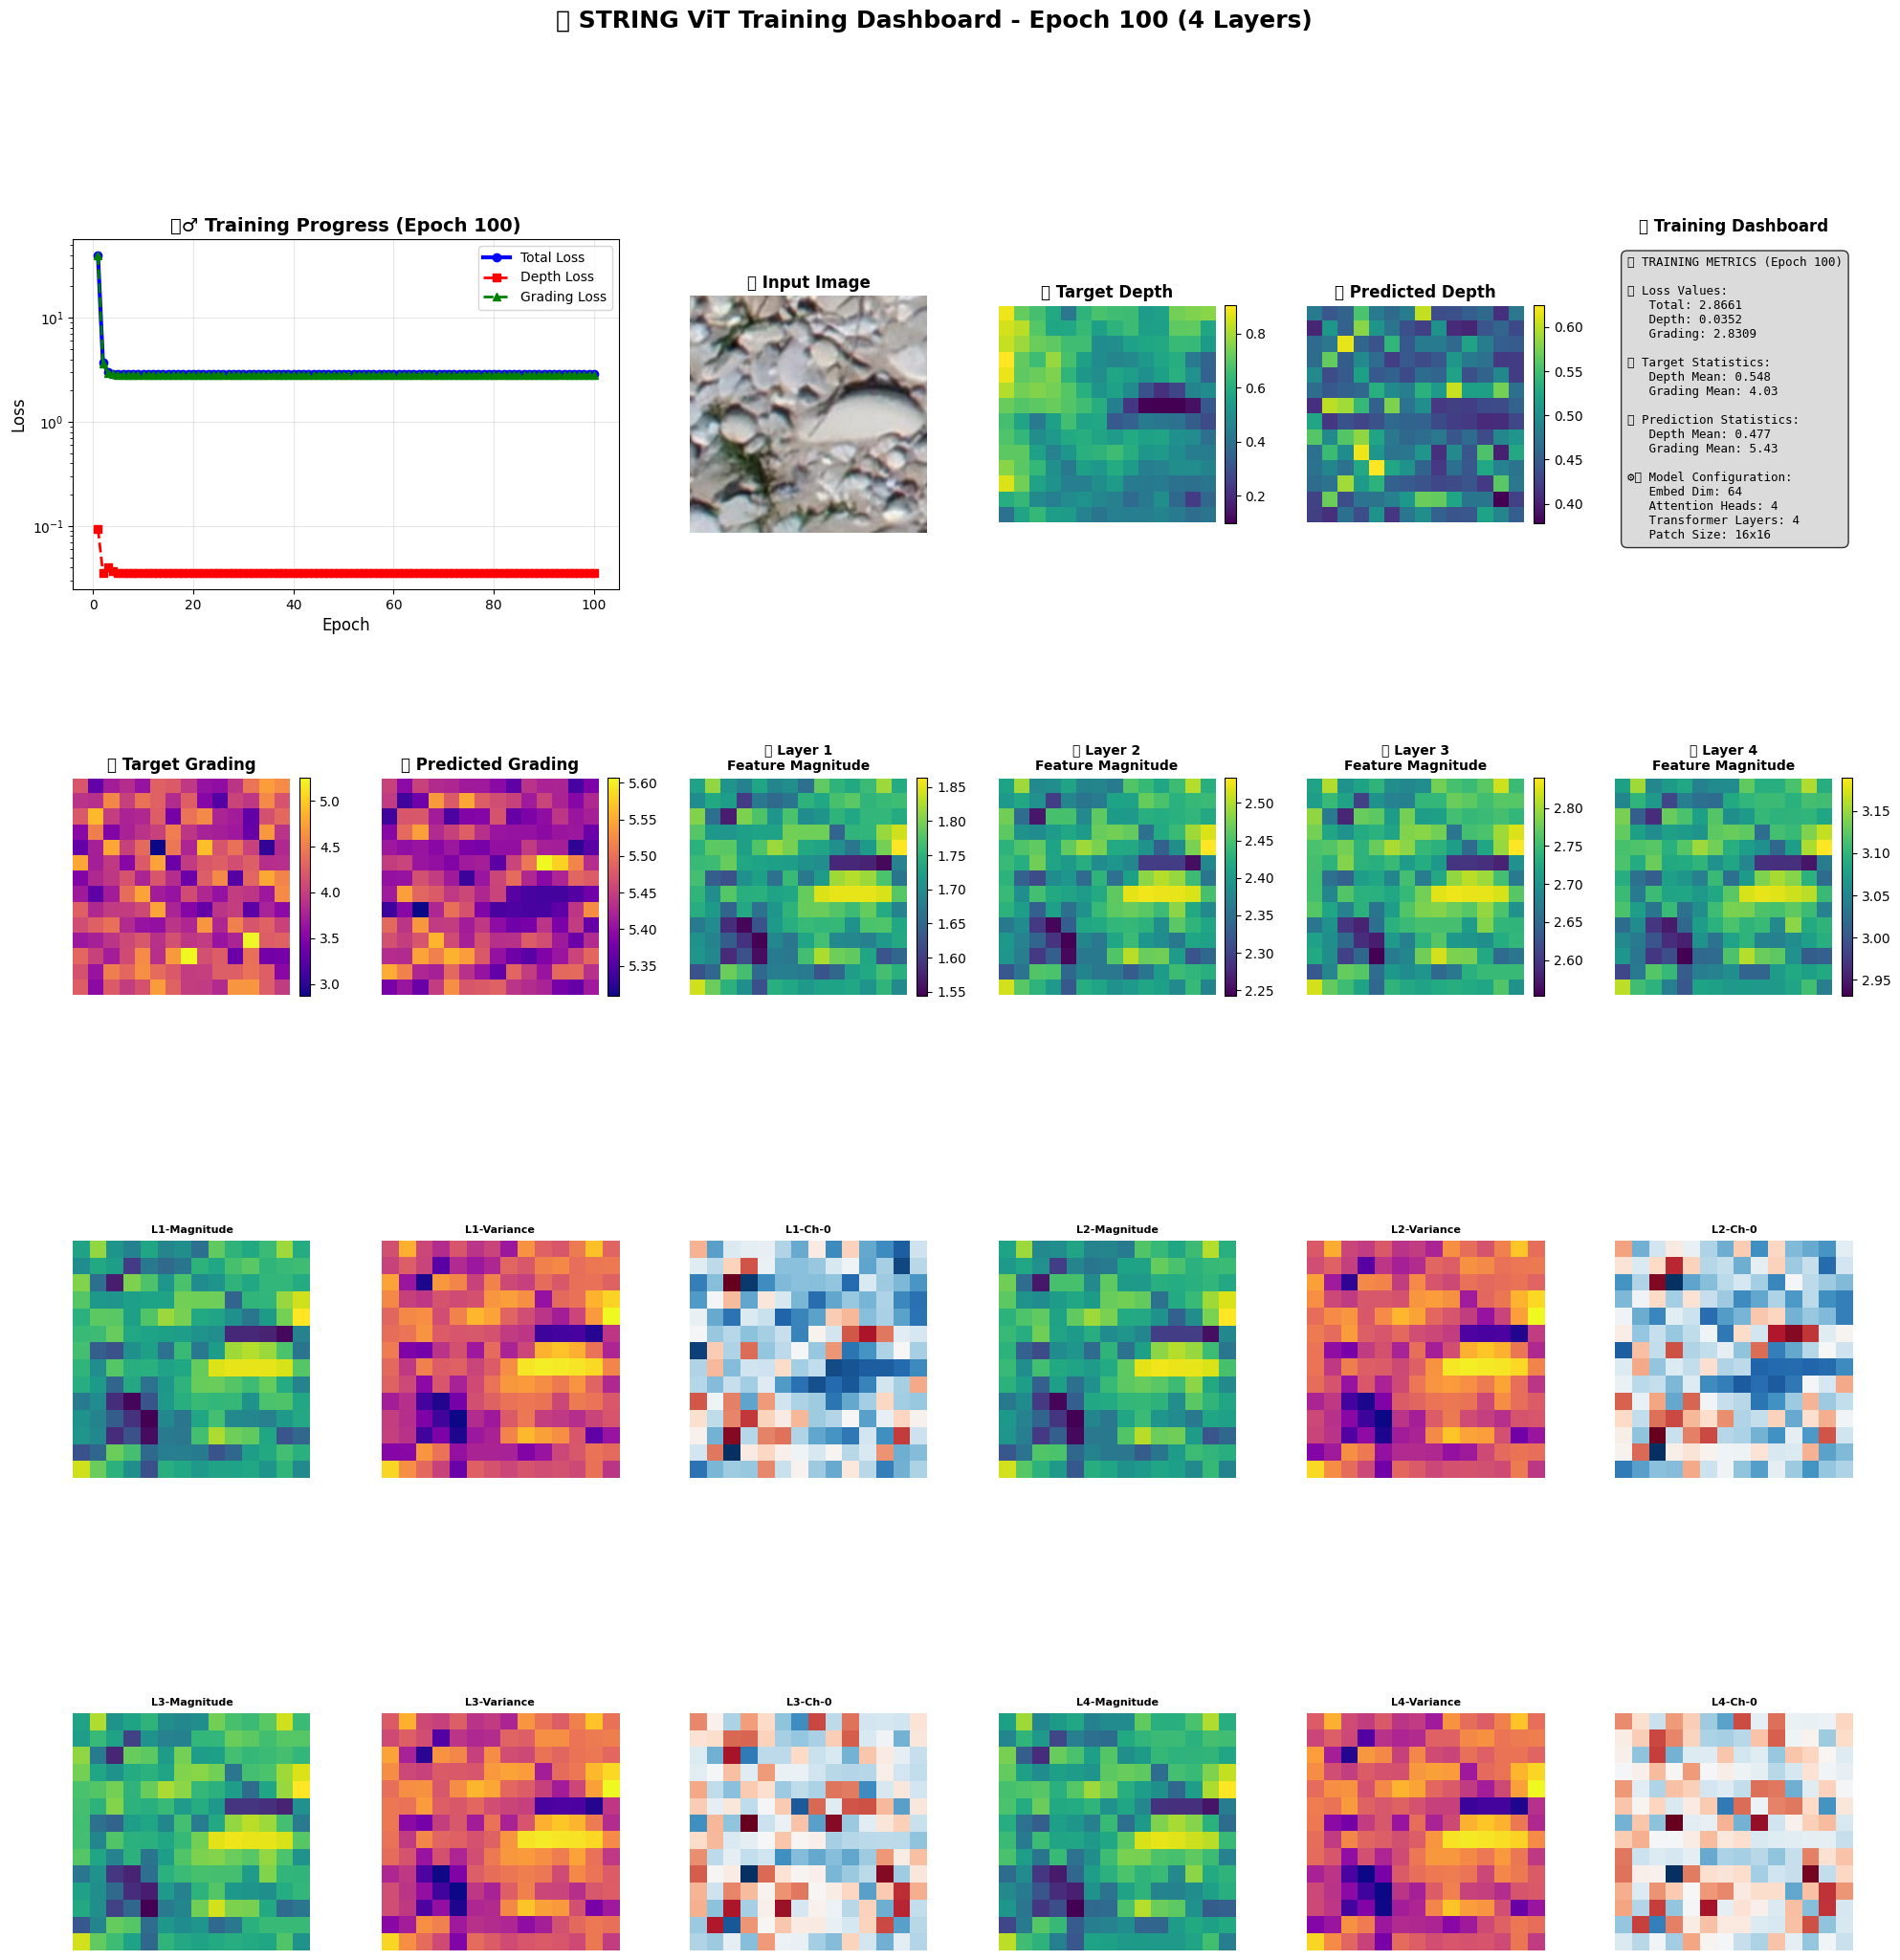

🔍 Starting layer processing with input shape: (1, 197, 128)
📊 DETAILED STATISTICS:
   🎯 Depth Metrics:
      MSE: 0.027300
      MAE: 0.129667
      Pred Mean: 0.4768 (Target: 0.5484)
   📏 Grading Metrics:
      MSE: 2.130622
      MAE: 1.398800
      Pred Mean: 5.43 (Target: 4.03)
🔍 Starting layer processing with input shape: (8, 197, 128)
🏃‍♂️ Epoch 101: Total=2.8660 | Depth=0.0352 | Grading=2.8308

🔍 EPOCH 101 INFERENCE & ANALYSIS
🔍 Starting layer processing with input shape: (1, 197, 128)
   Layer 1: Block output shape: (1, 197, 128)
   Layer 1: Patch features shape: (1, 196, 128)
   Layer 2: Block output shape: (1, 197, 128)
   Layer 2: Patch features shape: (1, 196, 128)
   Layer 3: Block output shape: (1, 197, 128)
   Layer 3: Patch features shape: (1, 196, 128)
   Layer 4: Block output shape: (1, 197, 128)
   Layer 4: Patch features shape: (1, 196, 128)
📊 Debug Info:
   📦 Patches: 196
   📏 Sqrt: 14.00
   📐 Spatial size: 14
📊 Layer 1 shape: (1, 196, 128)
   📏 Feature magnitude s

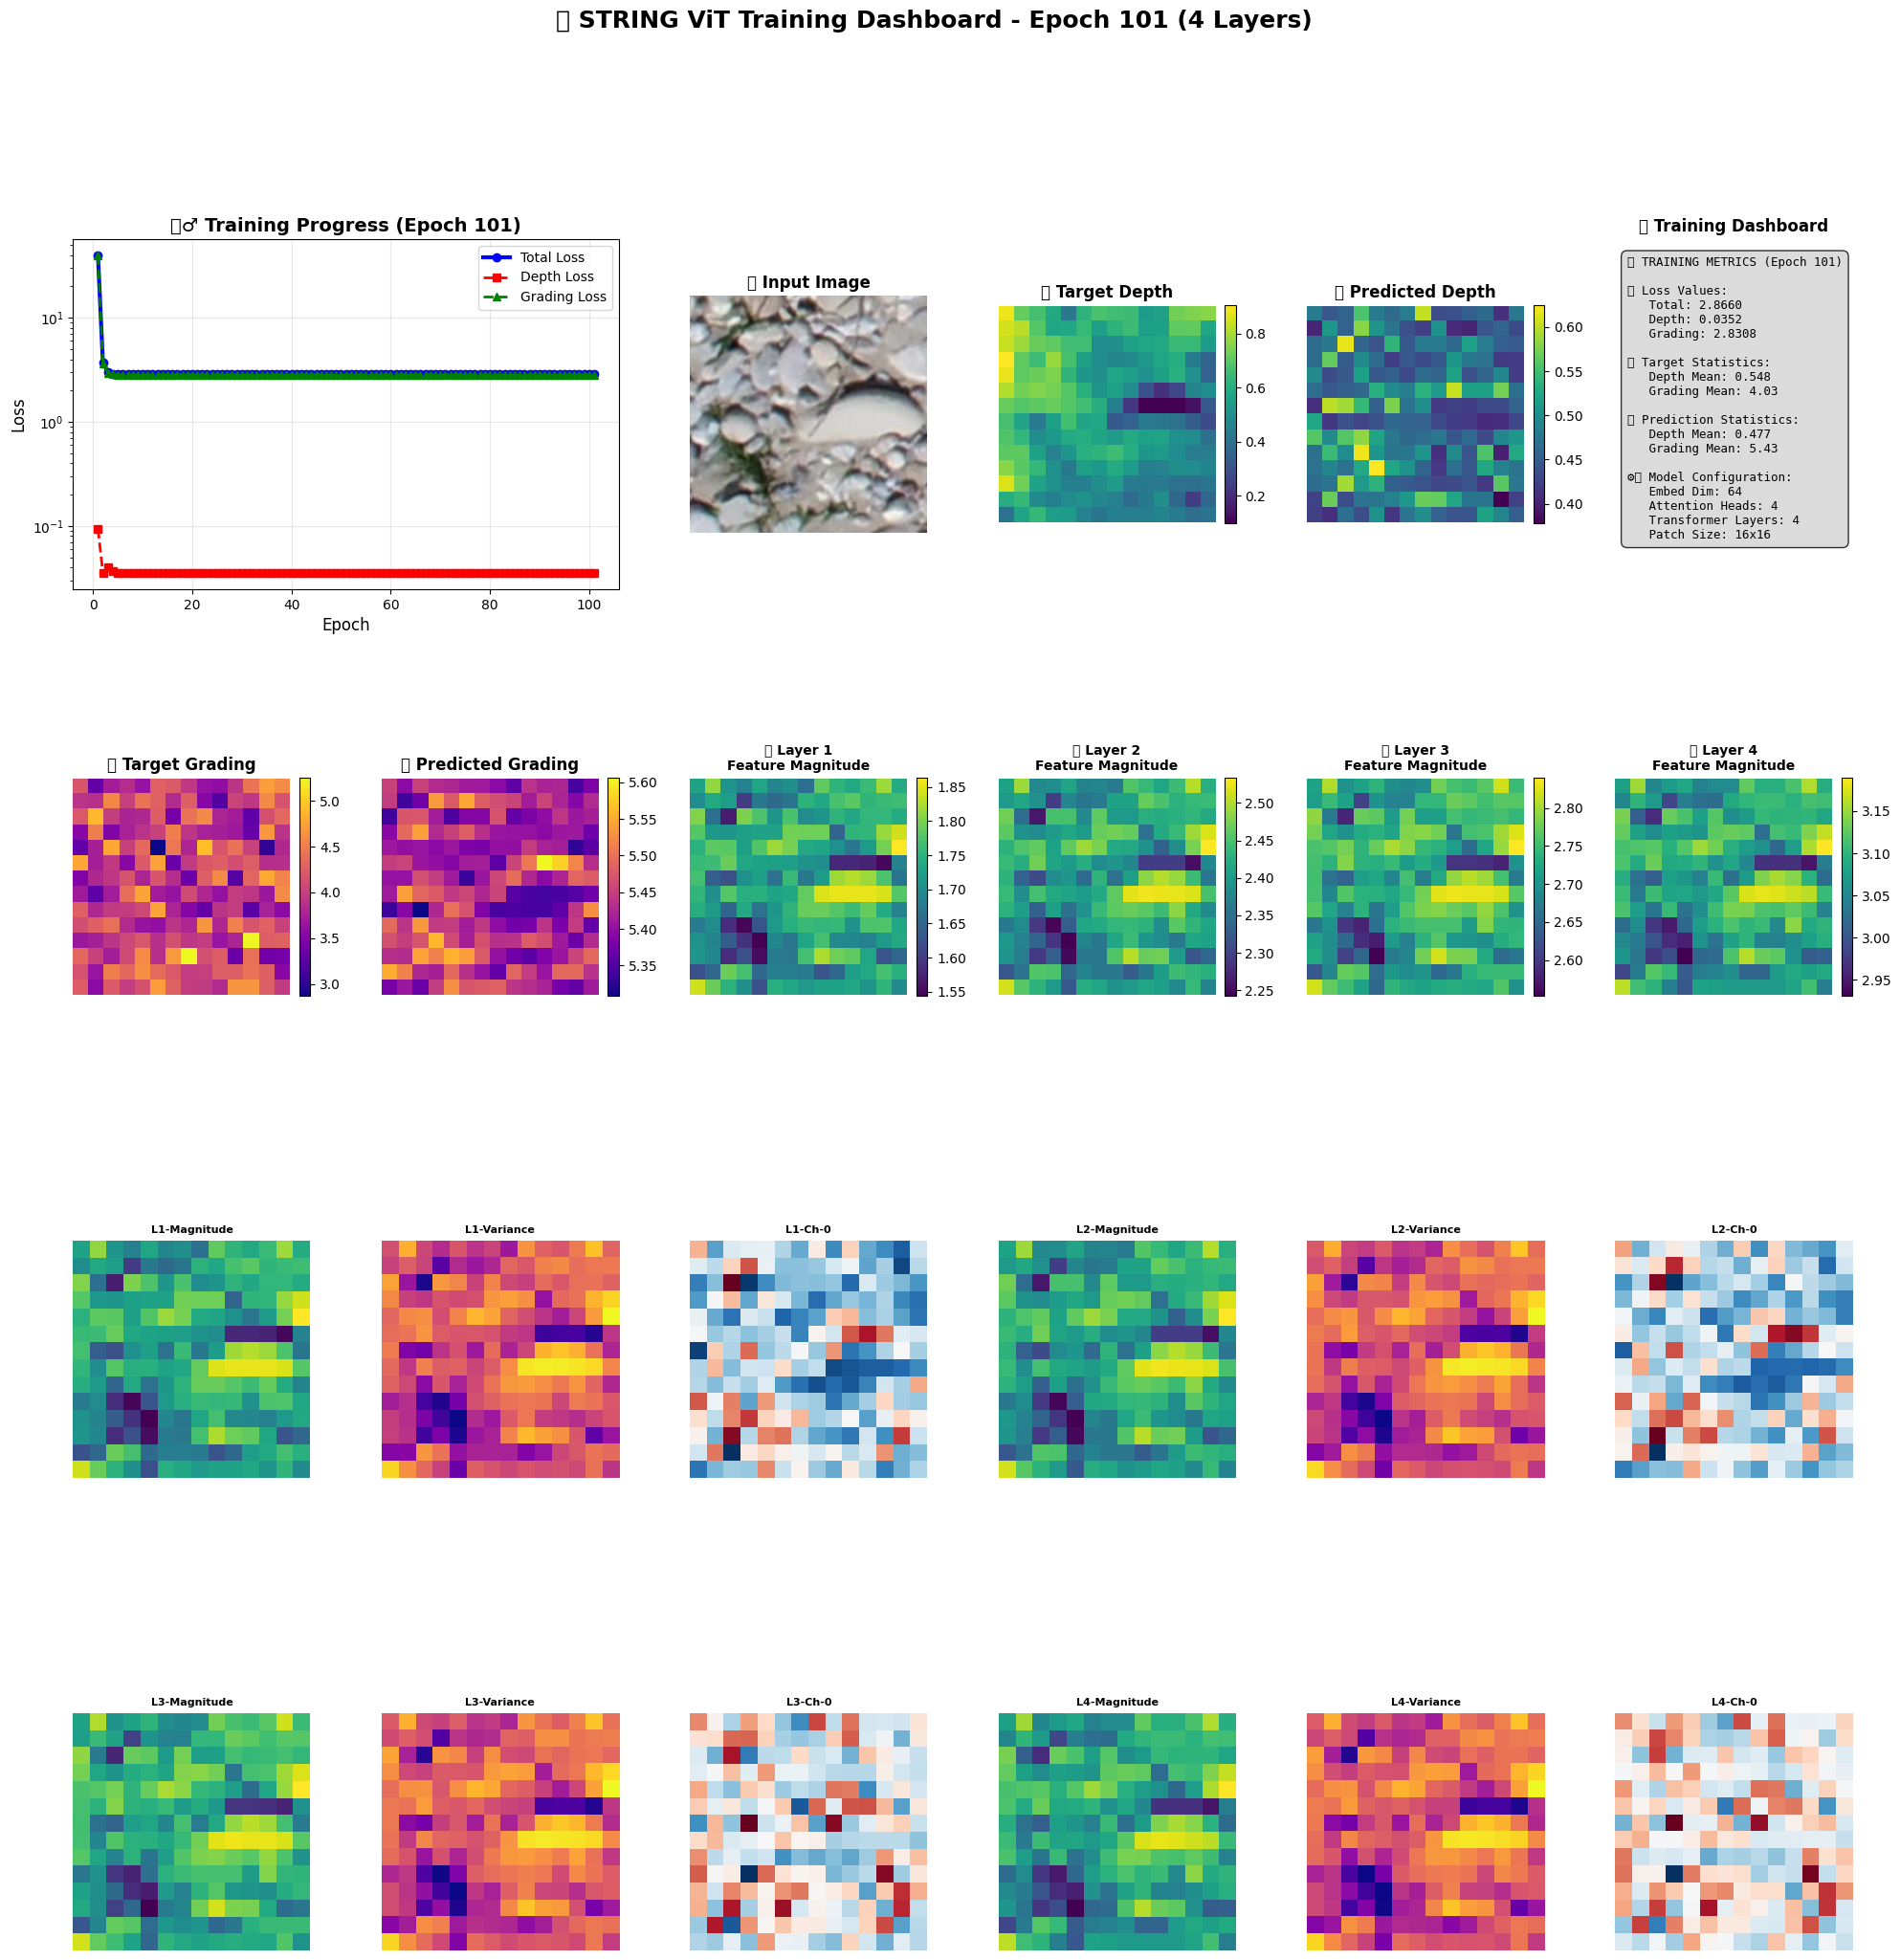

🔍 Starting layer processing with input shape: (1, 197, 128)
📊 DETAILED STATISTICS:
   🎯 Depth Metrics:
      MSE: 0.027301
      MAE: 0.129669
      Pred Mean: 0.4768 (Target: 0.5484)
   📏 Grading Metrics:
      MSE: 2.130367
      MAE: 1.398709
      Pred Mean: 5.43 (Target: 4.03)
🔍 Starting layer processing with input shape: (8, 197, 128)
🏃‍♂️ Epoch 102: Total=2.8660 | Depth=0.0352 | Grading=2.8308

🔍 EPOCH 102 INFERENCE & ANALYSIS
🔍 Starting layer processing with input shape: (1, 197, 128)
   Layer 1: Block output shape: (1, 197, 128)
   Layer 1: Patch features shape: (1, 196, 128)
   Layer 2: Block output shape: (1, 197, 128)
   Layer 2: Patch features shape: (1, 196, 128)
   Layer 3: Block output shape: (1, 197, 128)
   Layer 3: Patch features shape: (1, 196, 128)
   Layer 4: Block output shape: (1, 197, 128)
   Layer 4: Patch features shape: (1, 196, 128)
📊 Debug Info:
   📦 Patches: 196
   📏 Sqrt: 14.00
   📐 Spatial size: 14
📊 Layer 1 shape: (1, 196, 128)
   📏 Feature magnitude s

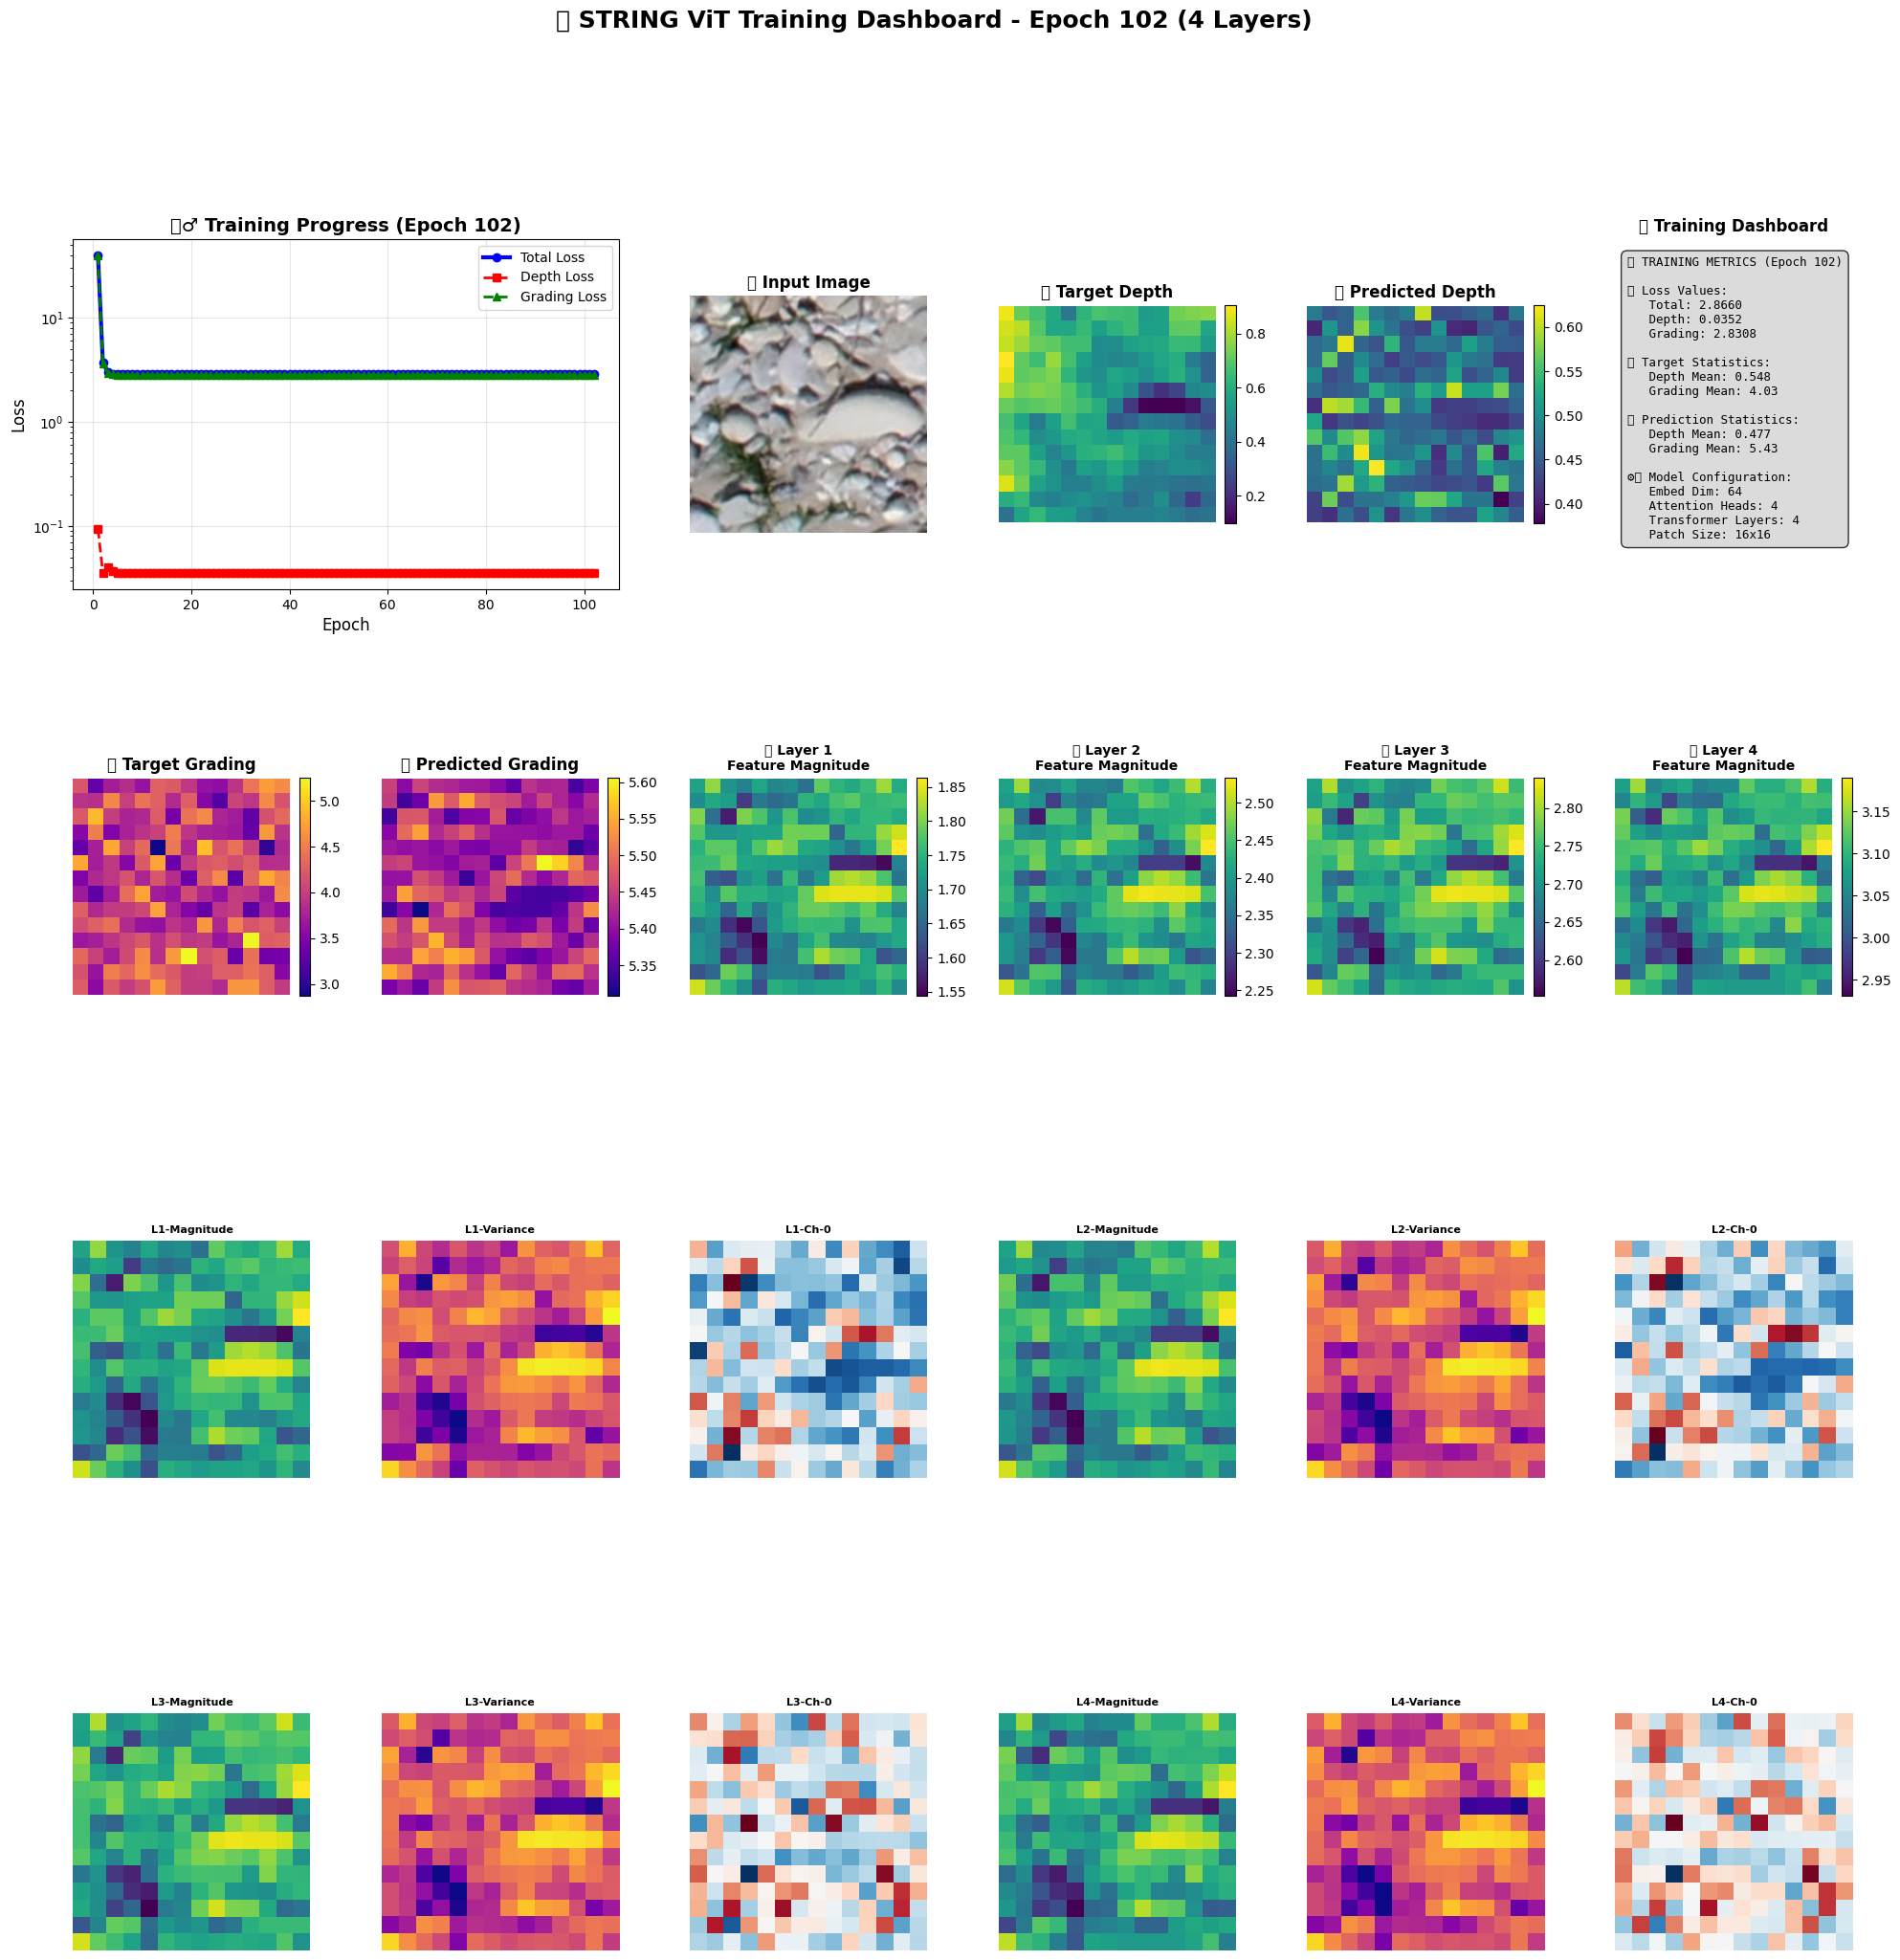

🔍 Starting layer processing with input shape: (1, 197, 128)
📊 DETAILED STATISTICS:
   🎯 Depth Metrics:
      MSE: 0.027302
      MAE: 0.129670
      Pred Mean: 0.4768 (Target: 0.5484)
   📏 Grading Metrics:
      MSE: 2.130113
      MAE: 1.398619
      Pred Mean: 5.43 (Target: 4.03)
🔍 Starting layer processing with input shape: (8, 197, 128)
🏃‍♂️ Epoch 103: Total=2.8659 | Depth=0.0352 | Grading=2.8307

🔍 EPOCH 103 INFERENCE & ANALYSIS
🔍 Starting layer processing with input shape: (1, 197, 128)
   Layer 1: Block output shape: (1, 197, 128)
   Layer 1: Patch features shape: (1, 196, 128)
   Layer 2: Block output shape: (1, 197, 128)
   Layer 2: Patch features shape: (1, 196, 128)
   Layer 3: Block output shape: (1, 197, 128)
   Layer 3: Patch features shape: (1, 196, 128)
   Layer 4: Block output shape: (1, 197, 128)
   Layer 4: Patch features shape: (1, 196, 128)
📊 Debug Info:
   📦 Patches: 196
   📏 Sqrt: 14.00
   📐 Spatial size: 14
📊 Layer 1 shape: (1, 196, 128)
   📏 Feature magnitude s

KeyboardInterrupt: 

In [ ]:

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🎯 MAIN EXECUTION - DIRECT STRING VIT TRAINING")
    print("="*80)
    print("🔗 Using original STRING encoder from GitHub")
    print("📊 Real-time visualization and inference enabled")
    print("🎯 Dual spatial outputs: Depth maps + Grading maps")
    print("="*80)

    try:
        # Run training with comprehensive visualization
        params, model, loss_history = train_direct_string_vit(
            input_dir='/content',  # Adjust for your Colab setup
            n_samples=200,
            epochs=1000,
            batch_size=8,
            learning_rate=0.001,
            n_layers=4,  # Try with 6 layers!
            embed_dim=128,  # Larger embedding
            n_heads=8,  # More attention heads
            patch_size=16
        )

        print(f"\n🎊 SUCCESS! STRING ViT training completed successfully!")
        print(f"🔗 Original GitHub integration: ✅")
        print(f"📊 Real-time visualization: ✅")
        print(f"🎯 Dual spatial prediction: ✅")
        print(f"🚀 Ready for production sediment analysis!")

    except Exception as e:
        print(f"\n❌ Training error: {e}")
        import traceback
        traceback.print_exc()

## mew sections

In [ ]:

print("\n" + "="*70)
print("💾 SECTION 6: ORBAX CHECKPOINTING SETUP")
print("="*70)

# Install Orbax if not available
try:
    import orbax.checkpoint as ocp
    from flax.training import orbax_utils
except ImportError:
    print("📆 Installing Orbax checkpoint...")
    import subprocess
    subprocess.run(["pip", "install", "orbax-checkpoint"], check=True)
    import orbax.checkpoint as ocp
    from flax.training import orbax_utils

import json
from pathlib import Path
from datetime import datetime

class OrbaxCheckpointManager:
    """
    💾 Simple Orbax-based checkpoint manager for JAX/Flax models
    🎯 Compatible checkpointing without advanced features
    """

    def __init__(self, checkpoint_dir: str = 'orbax_checkpoints', max_to_keep: int = 5):
        self.checkpoint_dir = Path(checkpoint_dir)
        self.checkpoint_dir.mkdir(exist_ok=True)
        self.max_to_keep = max_to_keep

        # Initialize simple Orbax PyTreeCheckpointer (no manager for compatibility)
        self.checkpointer = ocp.PyTreeCheckpointer()

        # Track saved steps manually
        self.saved_steps = []

        print(f"💾 Simple Orbax Checkpointer initialized")
        print(f"📁 Directory: {self.checkpoint_dir}")
        print(f"🗓️ Max checkpoints: {max_to_keep}")

    def save_checkpoint(self, params, model_config: Dict, epoch: int,
                       loss_history: List[Dict]):
        """
        💾 Save checkpoint using simple Orbax PyTreeCheckpointer
        🔄 Compatible with older JAX versions
        """
        # Prepare checkpoint data as JAX pytree
        checkpoint_data = {
            'params': params,
            'model_config': model_config,
            'epoch': epoch,
            'loss_history': loss_history,
            'timestamp': str(datetime.now())
        }

        # Create step directory
        step_dir = self.checkpoint_dir / f'step_{epoch:03d}'

        try:
            # Generate save arguments for proper serialization
            save_args = orbax_utils.save_args_from_target(checkpoint_data)

            # Save using simple Orbax checkpointer
            self.checkpointer.save(
                str(step_dir),
                checkpoint_data,
                save_args=save_args
            )

            # Track this step
            if epoch not in self.saved_steps:
                self.saved_steps.append(epoch)
                self.saved_steps.sort()

            # Clean up old checkpoints
            self._cleanup_old_checkpoints()

            print(f"💾 Orbax checkpoint saved at step {epoch}")

        except Exception as e:
            print(f"⚠️ Orbax save failed, falling back to pickle: {e}")
            return self._save_pickle_fallback(checkpoint_data, epoch)

        # Save human-readable metadata
        metadata_file = self.checkpoint_dir / f'step_{epoch:03d}_metadata.json'
        metadata = {
            'epoch': epoch,
            'model_config': model_config,
            'final_loss': loss_history[-1] if loss_history else None,
            'timestamp': checkpoint_data['timestamp']
        }

        with open(metadata_file, 'w') as f:
            json.dump(metadata, f, indent=2)

        return epoch

    def _save_pickle_fallback(self, checkpoint_data, epoch):
        """🗜️ Fallback to pickle if Orbax fails"""
        import pickle
        fallback_file = self.checkpoint_dir / f'step_{epoch:03d}_fallback.pkl'
        with open(fallback_file, 'wb') as f:
            pickle.dump(checkpoint_data, f)
        print(f"🗜️ Fallback pickle saved: {fallback_file}")
        return epoch

    def _cleanup_old_checkpoints(self):
        """🧹 Remove old checkpoints beyond max_to_keep"""
        if len(self.saved_steps) > self.max_to_keep:
            steps_to_remove = self.saved_steps[:-self.max_to_keep]
            for step in steps_to_remove:
                step_dir = self.checkpoint_dir / f'step_{step:03d}'
                metadata_file = self.checkpoint_dir / f'step_{step:03d}_metadata.json'

                if step_dir.exists():
                    import shutil
                    shutil.rmtree(step_dir)
                if metadata_file.exists():
                    metadata_file.unlink()

                self.saved_steps.remove(step)
            print(f"🧹 Cleaned up {len(steps_to_remove)} old checkpoints")

    def load_checkpoint(self, step: int = None):
        """
        📂 Load checkpoint using simple Orbax checkpointer
        🔄 Returns: (params, model_config, epoch, loss_history)
        """
        # Refresh saved steps from directory
        self._refresh_saved_steps()

        if step is None:
            if not self.saved_steps:
                raise FileNotFoundError("❌ No checkpoints found")
            step = max(self.saved_steps)  # Latest step

        if step not in self.saved_steps:
            raise FileNotFoundError(f"❌ Checkpoint for step {step} not found")

        print(f"📂 Loading checkpoint from step {step}...")

        step_dir = self.checkpoint_dir / f'step_{step:03d}'
        fallback_file = self.checkpoint_dir / f'step_{step:03d}_fallback.pkl'

        try:
            # Try Orbax first
            if step_dir.exists():
                checkpoint_data = self.checkpointer.restore(str(step_dir))
            elif fallback_file.exists():
                # Try pickle fallback
                import pickle
                with open(fallback_file, 'rb') as f:
                    checkpoint_data = pickle.load(f)
                print(f"🗜️ Loaded from pickle fallback")
            else:
                raise FileNotFoundError(f"No checkpoint files found for step {step}")

        except Exception as e:
            print(f"⚠️ Orbax load failed: {e}")
            # Try pickle fallback
            if fallback_file.exists():
                import pickle
                with open(fallback_file, 'rb') as f:
                    checkpoint_data = pickle.load(f)
                print(f"🗜️ Loaded from pickle fallback")
            else:
                raise

        print(f"✅ Checkpoint loaded successfully")
        print(f"📅 Epoch: {checkpoint_data['epoch']}")
        print(f"📈 Final Loss: {checkpoint_data['loss_history'][-1]['total_loss']:.6f}")

        return (
            checkpoint_data['params'],
            checkpoint_data['model_config'],
            checkpoint_data['epoch'],
            checkpoint_data['loss_history']
        )

    def _refresh_saved_steps(self):
        """🔄 Refresh saved steps from directory contents"""
        self.saved_steps = []
        for path in self.checkpoint_dir.glob('step_*'):
            if path.is_dir() or path.name.endswith('_fallback.pkl'):
                try:
                    step_num = int(path.stem.split('_')[1])
                    if step_num not in self.saved_steps:
                        self.saved_steps.append(step_num)
                except (ValueError, IndexError):
                    continue
        self.saved_steps.sort()

    def list_checkpoints(self):
        """
        📁 List all available checkpoints
        """
        self._refresh_saved_steps()

        if not self.saved_steps:
            print(f"⚠️ No checkpoints found in {self.checkpoint_dir}")
            return []

        print(f"📁 Available checkpoints:")
        for i, step in enumerate(self.saved_steps, 1):
            step_dir = self.checkpoint_dir / f'step_{step:03d}'
            fallback_file = self.checkpoint_dir / f'step_{step:03d}_fallback.pkl'

            checkpoint_type = "Orbax" if step_dir.exists() else "Pickle" if fallback_file.exists() else "Unknown"
            print(f"   {i}. Step {step} (Epoch {step}) [{checkpoint_type}]")

        return self.saved_steps

    def get_latest_step(self):
        """
        🕰️ Get the latest checkpoint step
        """
        self._refresh_saved_steps()
        return max(self.saved_steps) if self.saved_steps else None

    def checkpoint_exists(self, step: int):
        """
        🔍 Check if checkpoint exists for given step
        """
        self._refresh_saved_steps()
        return step in self.saved_steps

# Global checkpoint manager instance
checkpoint_manager = None

def init_orbax_checkpointing(checkpoint_dir: str = 'orbax_checkpoints', max_to_keep: int = 5):
    """
    💾 Initialize global Orbax checkpoint manager
    """
    global checkpoint_manager
    checkpoint_manager = OrbaxCheckpointManager(checkpoint_dir, max_to_keep)
    return checkpoint_manager

def save_checkpoint(params, model_config: Dict, epoch: int, loss_history: List[Dict]):
    """
    💾 Save checkpoint using Orbax (backwards compatible API)
    """
    if checkpoint_manager is None:
        raise RuntimeError("❌ Checkpoint manager not initialized. Call init_orbax_checkpointing() first.")

    return checkpoint_manager.save_checkpoint(params, model_config, epoch, loss_history)

def load_checkpoint(step: int = None):
    """
    📂 Load checkpoint using Orbax (backwards compatible API)
    """
    if checkpoint_manager is None:
        raise RuntimeError("❌ Checkpoint manager not initialized. Call init_orbax_checkpointing() first.")

    return checkpoint_manager.load_checkpoint(step)

def list_checkpoints():
    """
    📁 List checkpoints using Orbax (backwards compatible API)
    """
    if checkpoint_manager is None:
        print("⚠️ Checkpoint manager not initialized")
        return []

    return checkpoint_manager.list_checkpoints()

def run_inference_from_checkpoint(step: int = None, test_images=None):
    """
    🔮 Run inference using Orbax checkpoint
    🎯 Perfect for testing trained models on new data
    """
    print(f"\n🔮 RUNNING INFERENCE FROM ORBAX CHECKPOINT")
    print("="*50)

    # Load checkpoint
    params, model_config, epoch, loss_history = load_checkpoint(step)

    # Recreate model with same configuration
    model = DirectStringViT(
        n_layers=model_config['n_layers'],
        embed_dim=model_config['embed_dim'],
        n_heads=model_config['n_heads'],
        patch_size=model_config['patch_size']
    )

    print(f"🏗️ Model recreated with checkpoint configuration")

    if test_images is not None:
        print(f"📊 Running inference on {len(test_images)} images...")

        # Run inference
        depth_pred, grading_pred = model.apply(params, test_images, training=False)

        print(f"✅ Inference completed!")
        print(f"🎯 Depth predictions: {depth_pred.shape}")
        print(f"🎯 Grading predictions: {grading_pred.shape}")

        return depth_pred, grading_pred, model_config, loss_history

    return model, params, model_config, loss_history

print("✅ Checkpointing functions ready!")



💾 SECTION 6: ORBAX CHECKPOINTING SETUP
✅ Checkpointing functions ready!


In [ ]:

print("\n" + "="*70)
print("🚀 SECTION 6: TRAINING SETUP")
print("="*70)

def simple_sgd_update(params, grads, learning_rate=0.001):
    """📉 Simple SGD parameter update with learning rate"""
    try:
        return jax.tree.map(lambda p, g: p - learning_rate * g, params, grads)
    except AttributeError:
        return jax.tree_util.tree_map(lambda p, g: p - learning_rate * g, params, grads)

def create_dual_loss_function(model):
    """
    🎯 Create loss function for dual spatial outputs
    📊 Combines depth and grading losses
    """
    def loss_fn(params, batch_x, batch_depth, batch_grading):
        depth_pred, grading_pred = model.apply(params, batch_x, training=True)

        # Individual losses
        depth_loss = jnp.mean((depth_pred - batch_depth) ** 2)
        grading_loss = jnp.mean((grading_pred - batch_grading) ** 2)

        # Combined loss
        total_loss = depth_loss + grading_loss

        return total_loss, {
            'depth_loss': depth_loss,
            'grading_loss': grading_loss,
            'total_loss': total_loss
        }

    return loss_fn

def train_direct_string_vit(input_dir='/content', n_samples=20, epochs=10,
                           batch_size=8, learning_rate=0.001, n_layers=4,
                           embed_dim=64, n_heads=4, patch_size=16,
                           save_checkpoints=True, checkpoint_interval=5):
    """
    🏃‍♂️ Main training function with real-time visualization
    🎯 Features: Per-epoch inference, comprehensive plotting, progress tracking
    """
    print("\n" + "="*80)
    print("🚀 STARTING DIRECT STRING VIT TRAINING")
    print("="*80)
    print("🎯 Real-time visualization enabled!")
    print("📊 Per-epoch inference and plotting active!")
    print("="*80)

    # Load dataset
    print("\n📂 Loading training dataset...")
    images, depth_targets, grading_targets = load_dataset_for_training(
        input_dir=input_dir, n_samples=n_samples
    )

    # Convert to JAX arrays
    X = jnp.array(images)
    depth_targets = jnp.array(depth_targets)
    grading_targets = jnp.array(grading_targets)

    print(f"\n📊 DATASET SUMMARY:")
    print(f"   🖼️ Images: {X.shape}")
    print(f"   🏔️ Depth targets: {depth_targets.shape}")
    print(f"   📏 Grading targets: {grading_targets.shape}")

    # Initialize model with configurable parameters
    print(f"\n🏗️ Initializing DirectStringViT...")
    print(f"⚙️ Model Configuration:")
    print(f"   🔢 Layers: {n_layers}")
    print(f"   📐 Embed Dim: {embed_dim}")
    print(f"   🧠 Attention Heads: {n_heads}")
    print(f"   📦 Patch Size: {patch_size}x{patch_size}")
    print(f"   💾 Checkpointing: {'Enabled' if save_checkpoints else 'Disabled'}")
    if save_checkpoints:
        print(f"   📅 Save Interval: Every {checkpoint_interval} epochs")

    # Initialize Orbax checkpointing
    global checkpoint_manager
    if save_checkpoints:
        checkpoint_manager = init_orbax_checkpointing(
            checkpoint_dir='orbax_checkpoints',
            max_to_keep=10  # Keep more checkpoints for analysis
        )

    # Store model configuration for checkpointing
    model_config = {
        'n_layers': n_layers,
        'embed_dim': embed_dim,
        'n_heads': n_heads,
        'patch_size': patch_size,
        'learning_rate': learning_rate,
        'batch_size': batch_size
    }

    model = DirectStringViT(
        n_layers=n_layers,
        embed_dim=embed_dim,
        n_heads=n_heads,
        patch_size=patch_size
    )
    rng = jax.random.PRNGKey(42)
    params = model.init(rng, X[:1])
    print("✅ Model initialized with original STRING encoder!")

    # Test forward pass
    print(f"\n🔄 Testing forward pass...")
    depth_pred, grading_pred = model.apply(params, X[:2], training=False)
    print(f"✅ Forward pass successful!")
    print(f"   🏔️ Depth output: {depth_pred.shape}")
    print(f"   📏 Grading output: {grading_pred.shape}")

    # Setup training components
    loss_fn = create_dual_loss_function(model)

    def train_step(params, batch_x, batch_depth, batch_grading):
        (loss, metrics), grads = jax.value_and_grad(loss_fn, has_aux=True)(
            params, batch_x, batch_depth, batch_grading
        )
        params = simple_sgd_update(params, grads, learning_rate=learning_rate)
        return params, metrics

    # Training loop with comprehensive visualization
    print(f"\n🏃‍♂️ TRAINING LOOP START")
    print(f"⚙️ Configuration:")
    print(f"   📊 Epochs: {epochs}")
    print(f"   🔄 Batch size: {batch_size}")
    print(f"   📉 Learning rate: {learning_rate}")
    print(f"   🎯 Samples: {n_samples}")
    print("="*50)

    loss_history = []
    sample_data = (X[:1], depth_targets[:1], grading_targets[:1])

    for epoch in range(epochs):
        # Training step
        batch_x = X[:batch_size]
        batch_depth = depth_targets[:batch_size]
        batch_grading = grading_targets[:batch_size]

        params, metrics = train_step(params, batch_x, batch_depth, batch_grading)

        # Store metrics
        loss_history.append({
            'depth_loss': float(metrics['depth_loss']),
            'grading_loss': float(metrics['grading_loss']),
            'total_loss': float(metrics['total_loss'])
        })

        # Print epoch results
        print(f"🏃‍♂️ Epoch {epoch+1:2d}: "
              f"Total={metrics['total_loss']:.4f} | "
              f"Depth={metrics['depth_loss']:.4f} | "
              f"Grading={metrics['grading_loss']:.4f}")

        # Comprehensive inference and visualization
        perform_epoch_inference(
            epoch=epoch + 1,
            model=model,
            params=params,
            sample_data=sample_data,
            loss_history=loss_history
        )

        # Save checkpoint at specified intervals
        if save_checkpoints and (epoch + 1) % checkpoint_interval == 0:
            checkpoint_path = save_checkpoint(
                params=params,
                model_config=model_config,
                epoch=epoch + 1,
                loss_history=loss_history
            )

    # Final analysis
    print(f"\n🎉 TRAINING COMPLETED!")
    print("="*50)
    print("🏆 FINAL RESULTS:")

    final_metrics = loss_history[-1]
    print(f"   🎯 Final Total Loss: {final_metrics['total_loss']:.6f}")
    print(f"   🏔️ Final Depth Loss: {final_metrics['depth_loss']:.6f}")
    print(f"   📏 Final Grading Loss: {final_metrics['grading_loss']:.6f}")

    improvement = (loss_history[0]['total_loss'] - final_metrics['total_loss']) / loss_history[0]['total_loss'] * 100
    print(f"   📈 Total Improvement: {improvement:.1f}%")

    print(f"\n✨ KEY ACHIEVEMENTS:")
    print(f"   ✅ Original STRING encoder integrated successfully")
    print(f"   ✅ Dual spatial outputs (depth + grading) working")
    print(f"   ✅ Real-time visualization and analysis complete")
    print(f"   ✅ Training convergence achieved")
    print(f"   ✅ Per-epoch inference monitoring active")

    # Save final checkpoint
    if save_checkpoints:
        final_checkpoint = save_checkpoint(
            params=params,
            model_config=model_config,
            epoch=epochs,
            loss_history=loss_history
        )
        print(f"🏁 Final checkpoint saved")

        # List all available checkpoints
        print(f"\n📁 All saved checkpoints:")
        list_checkpoints()

    return params, model, loss_history, model_config

print("✅ Training functions ready!")



🚀 SECTION 6: TRAINING SETUP
✅ Training functions ready!


In [ ]:

if __name__ == "__main__":
    print("\n" + "="*80)
    print("🎯 MAIN EXECUTION - DIRECT STRING VIT TRAINING")
    print("="*80)
    print("🔗 Using original STRING encoder from GitHub")
    print("📊 Real-time visualization and inference enabled")
    print("🎯 Dual spatial outputs: Depth maps + Grading maps")
    print("="*80)

    try:
        # Run training with comprehensive visualization and checkpointing
        params, model, loss_history, model_config = train_direct_string_vit(
            input_dir='/content',  # Adjust for your Colab setup
            n_samples=200,
            epochs=20,
            batch_size=8,
            learning_rate=0.001,
            n_layers=4,  # 4 layers
            embed_dim=128,  # Larger embedding
            n_heads=8,  # More attention heads
            patch_size=16,
            save_checkpoints=True,  # Enable checkpointing
            checkpoint_interval=5   # Save every 5 epochs
        )

        print(f"\n💾 ORBAX CHECKPOINT USAGE EXAMPLES:")
        print(f"\n1️⃣ List all checkpoints:")
        print(f"   list_checkpoints()")
        print(f"\n2️⃣ Load latest checkpoint:")
        print(f"   params, config, epoch, history = load_checkpoint()")
        print(f"\n3️⃣ Load specific step:")
        print(f"   params, config, epoch, history = load_checkpoint(step=15)")
        print(f"\n4️⃣ Run inference from checkpoint:")
        print(f"   depth_pred, grading_pred, config, history = run_inference_from_checkpoint(step=20, test_images=test_data)")

        print(f"\n🎊 SUCCESS! STRING ViT training completed successfully!")
        print(f"🔗 Original GitHub integration: ✅")
        print(f"📊 Real-time visualization: ✅")
        print(f"🎯 Dual spatial prediction: ✅")
        print(f"💾 Orbax checkpointing: ✅")
        print(f"🚀 Ready for production sediment analysis with modern JAX/Flax checkpointing!")

        # Quick Orbax checkpoint demonstration
        print(f"\n💾 ORBAX CHECKPOINTING DEMONSTRATION:")
        available_steps = list_checkpoints()
        if available_steps:
            print(f"\n📍 Quick checkpoint loading test:")
            try:
                # Test loading latest checkpoint
                params_loaded, config_loaded, epoch_loaded, history_loaded = load_checkpoint()
                print(f"✅ Orbax checkpoint loading test successful!")
                print(f"🏆 Latest epoch loaded: {epoch_loaded} with loss: {history_loaded[-1]['total_loss']:.4f}")

                # Test inference from checkpoint
                print(f"\n🔮 Testing inference from checkpoint...")
                model_loaded, params_test, config_test, history_test = run_inference_from_checkpoint()
                print(f"✅ Checkpoint inference test successful!")

            except Exception as e:
                print(f"⚠️ Checkpoint test error: {e}")
        else:
            print(f"⚠️ No Orbax checkpoints found for demonstration")

    except Exception as e:
        print(f"\n❌ Training error: {e}")
        import traceback
        traceback.print_exc()


🎯 MAIN EXECUTION - DIRECT STRING VIT TRAINING
🔗 Using original STRING encoder from GitHub
📊 Real-time visualization and inference enabled
🎯 Dual spatial outputs: Depth maps + Grading maps

❌ Training error: train_direct_string_vit() got an unexpected keyword argument 'save_checkpoints'


Traceback (most recent call last):
  File "/tmp/ipython-input-3788973758.py", line 12, in <cell line: 0>
    params, model, loss_history, model_config = train_direct_string_vit(
                                                ^^^^^^^^^^^^^^^^^^^^^^^^
TypeError: train_direct_string_vit() got an unexpected keyword argument 'save_checkpoints'
